## Selective Classification Can Magnify Disparities Across Groups


### AM207: Advanced Scientific Computing

#### Team: Jamelle Watson-Daniels, Shirley Wang, Bridger Ruyle, Paul Tembo

#### Paper: https://arxiv.org/pdf/2010.14134.pdfODOS: 

Minimal goal: Investigate how selective classification affects group accuracy on a synthetic `mnist` dataset
- Generate synthetic dataset from `mnist`
- Train empirical risk minimization model (minimize loss - Logistic regression i.e. ResNet)    
- Calculate average coverage
- Calculate group coverage
- Calculate selective accuracy
- Plot average coverage vs group coverage for `mnist` dataset
- Plot average coverage vs selective accuracy for `mnist` dataset

If there is time goal: Show that selective accuracies on average and on the worst-group are determined by their respective margin distributions
- Calculate margin
- Calculate worst-group density
- Calculate Average density
- Plot margin (-10,+10) versus worst-group density
- Plot margin (-10,+10) versus Average density

Possible extensions: What are the characteristics of this dataset that are imbalanced and contain spurious correlations? We see that in all these datasets, the "worst group" is underrepresented as in there are much fewer examples for the "worst group" category. Notice that the datasets considered in this paper do not seem immediately relevant in terms of the real world implications of disparities, we wonder how we might examine this using toy examples.

#### Dataset description
"Models have been shown to latch onto spurious correlations between labels and demographic attributes such as race and gender (Buolamwini & Gebru, 2018; Joshi et al., 2018), and we
study this on the CelebA dataset (Liu et al., 2015). Following Sagawa et al. (2020), we consider
the task of classifying hair color, which is spuriously correlated with the gender. Concretely, inputs
are celebrity face images, labels are hair color Y = {blond, non-blond}, and spurious attributes are
gender, A = {male, female}, with blondness associated with being female. Of the four groups,
blond males are the smallest group, with only 1,387 examples out of 162,770 training examples, and
they tend to be the worst group empirically. We use the official train-val-split of the dataset."

## Generate synthetic data 

Take the `mnist` dataset and consider the task of classifying digits 1 vs. 2. Alter the data such that the digit 1 is spuriously correlated with grey dots on the upper lefthand corner of the image. 

Concretely, inputs are `mnist` digits, labels are digit number Y = {1, 2}, and suprious attributes are grey boxes, A = {present, absent}, with added grey boxes associated with digit 2. Of the four groups, digit 1 with grey boxes are the smallest group. To mimic the `celebA` dataset in the original paper, we will alter the images such that approximately 8.5% of the training examples are digit 1 with grey boxes. 

In [1]:
from autograd import grad
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True)

In [3]:
# Pick out two classes of digits: 1, 2 and take a subset of samples 
X_subset = X[((y == '1') | (y == '2'))]
y_subset = y[((y == '1') | (y == '2'))]

# Encode the label '1' with y = 1, and the label '6' with y = 0
y_subset[y_subset == '1'] = 1
y_subset[y_subset == '2'] = 0
y_subset = y_subset.astype(int)

In [4]:
# Randomize our data 
random_state = check_random_state(0)
permutation = random_state.permutation(X_subset.shape[0])
X_subset = X_subset[permutation]
y_subset = y_subset[permutation]
X_subset = X_subset.reshape((X_subset.shape[0], -1))

In [33]:
# Split into training and testing sets
# Following celebA: 80% training, 10% val, 10% test 

X_train, X_test_tot, y_train, y_test_tot = train_test_split(X_subset, y_subset, test_size = 0.2) # split out train
X_val, X_test, y_val, y_test = train_test_split(X_test_tot, y_test_tot, test_size = 0.5) # split out validation set 

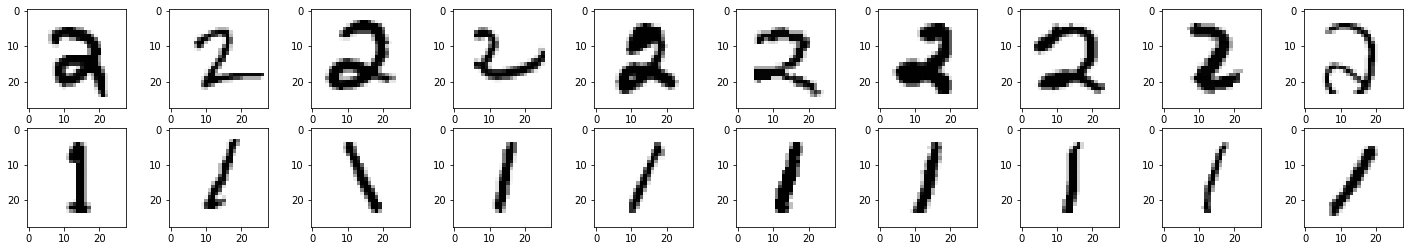

In [6]:
# Visualize some samples from the training dataset 
fig, ax = plt.subplots(2, 10, figsize = (25, 4))
for i in range(10):
    ax[0, i].imshow(X_train[y_train == 0][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')
    ax[1, i].imshow(X_train[y_train == 1][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')

In [34]:
# function to add a grey rectangular box to top left-hand corner of digit

def add_spurious_ft(x_array, y_array, perc_spurious_1, perc_spurious_2):
    '''
    x_array: array of shape (n_images, 784)
    y_array: array of shape (n_images, )
    perc_spurious_1: percent of digit 1 images to add spurious features to
    perc_spurious_2: percent of digit 1 images to add spurious features to

    returns: altered image array
    '''
    
    indices_1 = np.asarray(np.where(y_train == 1)).reshape(-1) # indices where digit = 1 
    indices_2 = np.asarray(np.where(y_train == 0)).reshape(-1) # indices where digit = 2 
    
    num_digit_1 = len(indices_1) # number of digit 1 images 
    num_digit_2 = len(indices_2) # number of digit 2 images 

    num_alter_1 = int(perc_spurious_1 * num_digit_1) # number of digit 1 images to alter
    num_alter_2 = int(perc_spurious_2 * num_digit_2) # number of digit 2 images to alter
    
    rand_indices_1 = np.random.choice(len(indices_1), size = num_alter_1, replace = False) 
    rand_indices_2 = np.random.choice(len(indices_2), size = num_alter_2, replace = False) 
    
    grey_boxes = np.r_[0:15, 28:43, 56:71]
    altered_imgs = x_array
    
    for i in range(len(altered_imgs)):
        
        # alter digit 2 images 
        if y_train[i] == 0:
            if i in rand_indices_2:
                altered_imgs[i][grey_boxes] = np.array([104] * len(grey_boxes))
        
        # alter digit 1 images 
        elif y_train[i] == 1:
            if i in rand_indices_1:
                altered_imgs[i][grey_boxes] = np.array([104] * len(grey_boxes))
    
    return altered_imgs

In [39]:
# test to see if the function works 
test_altered_imgs = add_spurious_ft(X_train, y_train, 0.085, 0.7)

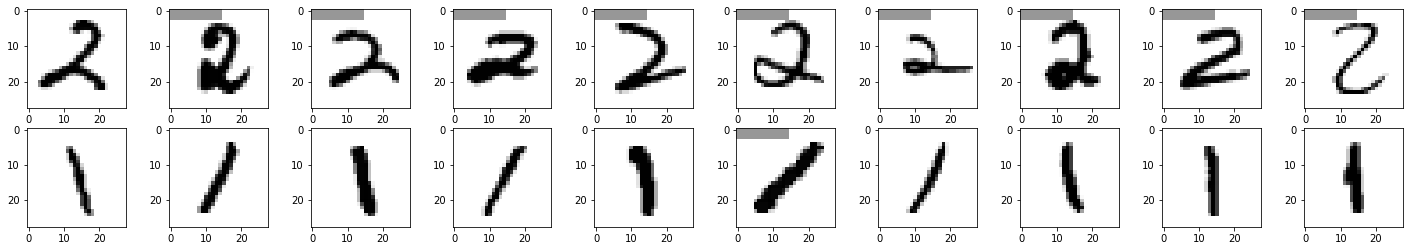

In [40]:
# Visualize some samples from the altered training dataset. more 2's with spurious features than 1's. seems to work! 
fig, ax = plt.subplots(2, 10, figsize = (25, 4))
for i in range(10):
    ax[0, i].imshow(test_altered_imgs[y_train == 0][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')
    ax[1, i].imshow(test_altered_imgs[y_train == 1][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')

## Generate 4 Sets of Image Datasets (Train, Val, Test): 

`X_train_9`, `X_val_9`, `X_test_9`: 90% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_7`, `X_val_7`, `X_test_7`: 70% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_5`, `X_val_5`, `X_test_5`: 50% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_3`, `X_val_3`, `X_test_3`: 30% spurious features in digit 2; 8.5% spurious features in digit 1.

In [10]:
# 90% spurious in digit 2 
X_train_9 = add_spurious_ft(X_train, y_train, 0.085, 0.9)
X_val_9 = add_spurious_ft(X_val, y_val, 0.085, 0.9)
X_test_9 = add_spurious_ft(X_test, y_test, 0.085, 0.9)

# 70% spurious in digit 2 
X_train_7 = add_spurious_ft(X_train, y_train, 0.085, 0.7)
X_val_7 = add_spurious_ft(X_val, y_val, 0.085, 0.7)
X_test_7 = add_spurious_ft(X_test, y_test, 0.085, 0.7)

# 50% spurious in digit 2 
X_train_5 = add_spurious_ft(X_train, y_train, 0.085, 0.5)
X_val_5 = add_spurious_ft(X_val, y_val, 0.085, 0.5)
X_test_5 = add_spurious_ft(X_test, y_test, 0.085, 0.5)

# 30% spurious in digit 2 
X_train_3 = add_spurious_ft(X_train, y_train, 0.085, 0.3)
X_val_3 = add_spurious_ft(X_val, y_val, 0.085, 0.3)
X_test_3 = add_spurious_ft(X_test, y_test, 0.085, 0.3)